In [ ]:
# installs

# notebook/colab
! pip install scikit-plot

In [ ]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

# what we need for today
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics 

import scikitplot as skplt

# color maps
from matplotlib import cm

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

DataFrames

- df
- temp
- df_2018
- stock (copy of df_2018)
- stock_num
- st (transformed)
- 

## Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/stock-fundamentals.csv"
df = pd.read_csv(path)

In [ ]:
df.shape

(755, 43)

In [ ]:
df.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end
0,NaN,3588919000,3588919000,1,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028,ORCL,2018-11-30
1,NaN,261043625,261043625,1,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151,FDX,2018-11-30
2,NaN,359091176,359091176,1,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283,PAYX,2018-11-30


In [ ]:
df.describe()

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio
count,0.0,7.550000e+02,7.550000e+02,755.0,7.550000e+02,6.330000e+02,7.550000e+02,6.330000e+02,7.550000e+02,7.550000e+02,7.550000e+02,7.550000e+02,7.550000e+02,7.520000e+02,7.550000e+02,7.550000e+02,755.000000,755.000000,755.000000,7.530000e+02,7.530000e+02,7.530000e+02,7.550000e+02,7.550000e+02,7.550000e+02,712.000000,712.000000,712.000000,692.000000,754.000000,755.000000,671.000000,616.000000,755.000000,653.000000,712.000000,712.000000,652.000000,748.000000,753.000000,633.000000
mean,NaN,4.911493e+08,4.911493e+08,1.0,6.107129e+10,7.512716e+09,4.941542e+10,5.626906e+09,1.135538e+10,3.004828e+08,2.471578e+08,6.943087e+09,1.325604e+10,4.567319e+09,4.325207e+08,4.101034e+08,15.986159,15.971364,0.308014,8.629677e+08,-4.121679e+08,-4.313689e+08,1.039072e+07,3.763882e+09,2.717754e+08,525.730843,571.091517,480.370028,0.151804,0.058858,328.093404,5.691684,39.212354,18.475483,0.591236,1.240045,0.372819,0.137426,0.766738,6.622138,1.838612
std,NaN,8.853124e+08,8.853124e+08,0.0,2.343986e+11,1.487448e+10,2.185426e+11,1.137258e+10,2.763748e+10,9.889860e+08,1.832846e+09,1.714686e+10,1.234353e+11,9.220713e+09,1.828721e+09,1.847186e+09,410.489825,410.490229,0.366153,2.350119e+09,2.514899e+09,2.735644e+09,2.135659e+09,2.024107e+10,6.412763e+08,11543.079379,12535.221949,10550.938854,0.197467,0.078665,8325.804594,12.727791,78.579622,37.210077,1.576597,3.693016,0.192265,0.118882,0.676155,149.894366,1.378521
min,NaN,1.641681e+06,1.641681e+06,1.0,1.414119e+07,1.324407e+07,1.272664e+06,1.250634e+06,-1.172000e+10,-2.647100e+08,0.000000e+00,0.000000e+00,0.000000e+00,3.414002e+06,-2.369800e+10,-2.388900e+10,-15.520000,-15.520000,0.000000,-7.261000e+09,-3.346100e+10,-2.763500e+10,-2.384200e+10,0.000000e+00,-6.820000e+08,1.060000,1.770000,0.120000,-0.939000,-0.446700,-65.800000,0.170000,1.440000,0.000000,0.000000,0.000000,0.002700,0.000600,0.010000,-18.740000,0.192100
25%,NaN,1.265114e+08,1.265114e+08,1.0,5.938500e+09,1.524000e+09,3.330460e+09,8.977000e+08,1.736500e+09,0.000000e+00,0.000000e+00,2.708150e+08,9.748150e+08,8.339000e+08,6.028600e+07,5.950000e+07,0.295000,0.290000,0.000000,9.747500e+07,-4.190000e+08,-3.730000e+08,-8.950000e+07,2.541105e+08,2.305300e+07,34.250000,37.985000,31.002500,0.069100,0.016350,9.290000,1.805000,14.737500,2.275000,0.084200,0.278800,0.229850,0.058275,0.320000,0.120000,1.047500
50%,NaN,2.442958e+08,2.442958e+08,1.0,1.383924e+10,3.014427e+09,8.873000e+09,2.137486e+09,4.554000e+09,5.000000e+05,0.000000e+00,1.894898e+09,3.245500e+09,1.743260e+09,1.693810e+08,1.662000e+08,0.800000,0.790000,0.205000,2.890000e+08,-9.500000e+07,-1.060000e+08,1.586000e+06,6.957180e+08,7.120000e+07,65.430000,70.750000,60.005000,0.137200,0.050600,18.320000,2.960000,21.790000,10.080000,0.302900,0.636700,0.362650,0.103850,0.600000,0.770000,1.498800
75%,NaN,4.788721e+08,4.788721e+08,1.0,3.648200e+10,6.632000e+09,2.493320e+10,5.031000e+09,1.044722e+10,1.200685e+08,0.000000e+00,6.303200e+09,8.684768e+09,4.063750e+09,4.925000e+08,4.890000e+08,1.550000,1.535000,0.462500,7.240220e+08,-1.340000e+07,-1.034000e+06,1.090000e+08,1.925078e+09,2.239500e+08,111.145000,119.515000,102.580000,0.233250,0.090200,32.510000,5.475000,35.192500,24.685000,0.579900,1.193225,0.504950,0.179975,0.962500,1.650000,2.127800
max,NaN,9.814197e+09,9.814197e+09,1.0,3.401

In [ ]:
df.dtypes

Quarter end                                   float64
Shares                                          int64
Shares split adjusted                           int64
Split factor                                    int64
Assets                                          int64
Current Assets                                float64
Liabilities                                     int64
Current Liabilities                           float64
Shareholders equity                             int64
Non-controlling interest                        int64
Preferred equity                                int64
Goodwill & intangibles                          int64
Long-term debt                                  int64
Revenue                                       float64
Earnings                                        int64
Earnings available for common stockholders      int64
EPS basic                                     float64
EPS diluted                                   float64
Dividend per share          

# Data Cleaning 

In [ ]:
#each ticker is unique
temp2 = df.copy()
temp2 = df.reset_index().groupby(['ticker'])['quarter_end'].nunique().reset_index()
temp2

,ticker,quarter_end
0,A,1
1,AA,1
2,AAN,1
3,AAP,1
4,AAPL,1
...,...,...
750,YHOO,1
751,YUM,1
752,ZION,1
753,ZMH,1


In [ ]:
#each ticker is unique
temp2[temp2['quarter_end'] >1].count()

ticker         0
quarter_end    0
dtype: int64

In [ ]:
#converting quarter_end to a datetime variable and creating additional features consisting of year, quarter and month 
df['quarter_end'] = pd.to_datetime(df['quarter_end'])
df['Year'] = df['quarter_end'].dt.year
df['Quarter'] = df['Year'].astype(str) + 'Q' + df['quarter_end'].dt.quarter.astype(str)
df['Yearmonth'] = df['Year'].astype(str) + 'M' + df['quarter_end'].dt.month.astype(str)

In [ ]:
#the dataset has observations from 2006-2018
df.Year.unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
       2007, 2006])

In [ ]:
#the dataset has observations from 2006-2018
df.groupby(['Year','Quarter'])['quarter_end'].count()

Year  Quarter
2006  2006Q3       1
2007  2007Q3       1
2008  2008Q1       4
      2008Q2       4
      2008Q3       9
      2008Q4       2
2009  2009Q1       1
      2009Q2       2
      2009Q3       3
      2009Q4       5
2010  2010Q1       1
      2010Q2       2
      2010Q3       3
      2010Q4       3
2011  2011Q1       4
      2011Q2       1
      2011Q4       4
2012  2012Q1       3
      2012Q2       1
      2012Q3       2
      2012Q4       1
2013  2013Q1       2
      2013Q2       1
      2013Q3       6
      2013Q4       2
2014  2014Q1       2
      2014Q2       1
      2014Q3       3
      2014Q4       7
2015  2015Q1       3
      2015Q2       7
      2015Q3       6
      2015Q4       3
2016  2016Q1       6
      2016Q2       7
      2016Q3       6
      2016Q4       5
2017  2017Q1       4
      2017Q2       5
      2017Q3       3
      2017Q4       4
2018  2018Q1       4
      2018Q2       7
      2018Q3     539
      2018Q4      65
Name: quarter_end, dtype: int64

In [ ]:
#only filtering for 2018 observations and creating a new dataframe 'df_2018'
df_2018 = df[(df['Year']== 2018) & (df['Quarter'] == '2018Q3')]

In [ ]:
# Most of the stock movement takes place in September 2018
df_2018.groupby(['Yearmonth', 'Quarter'])['Quarter'].count()

Yearmonth  Quarter
2018M8     2018Q3      16
2018M9     2018Q3     523
Name: Quarter, dtype: int64

In [ ]:
#filtering only for data in September 2018 
df_2018 = df_2018[df_2018['Yearmonth'] == '2018M9']

In [ ]:
df_2018.index = df_2018['ticker']

In [ ]:
df_2018.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
URI,NaN,81102622,81102622,1,16354000000,1.692000e+09,13020000000,2.087000e+09,3334000000,0,0,5208000000,9182000000,2.116000e+09,333000000,333000000,4.05,4.01,0.00,474000000.0,-1.388000e+09,8.630000e+08,-52000000,65000000,839000000,157.81,173.00,142.61,0.5317,0.1100,41.11,4.13,8.70,0.00,0.0000,2.7540,0.2039,0.2196,0.50,-4.50,0.8107,URI,2018-09-30,2018,2018Q3,2018M9
NWL,NaN,466800000,466800000,1,22398100000,1.220850e+10,16371900000,4.096700e+09,5993300000,32900000,0,8745000000,9296800000,2.277200e+09,-7311000000,-7311000000,-15.52,-15.52,0.23,572100000.0,9.890000e+07,-1.505100e+09,-835800000,1443600000,72700000,24.07,28.00,20.14,-0.4539,-0.1806,12.84,0.81,5.68,16.27,NaN,1.5512,0.2676,NaN,0.37,1.07,2.9801,NWL,2018-09-30,2018,2018Q3,2018M9
AJG,NaN,183652000,183652000,1,16114700000,8.084000e+09,11502000000,7.422600e+09,4544500000,68200000,0,6273400000,3141200000,1.778500e+09,127600000,127600000,0.70,0.68,0.41,191300000.0,-2.081000e+08,-4.480000e+07,-84200000,2260500000,28100000,70.75,76.49,65.00,0.1411,0.0405,24.75,2.91,20.93,23.61,0.4759,0.6912,0.2820,0.0904,0.45,0.89,1.0891,AJG,2018-09-30,2018,2018Q3,2018M9


In [ ]:
df_2018.isna().sum()

Quarter end                                   523
Shares                                          0
Shares split adjusted                           0
Split factor                                    0
Assets                                          0
Current Assets                                104
Liabilities                                     0
Current Liabilities                           104
Shareholders equity                             0
Non-controlling interest                        0
Preferred equity                                0
Goodwill & intangibles                          0
Long-term debt                                  0
Revenue                                         0
Earnings                                        0
Earnings available for common stockholders      0
EPS basic                                       0
EPS diluted                                     0
Dividend per share                              0
Cash from operating activities                  2


In [ ]:
#removing the Quarter End column since the date for quarter_end has already been given
df_2018.drop(columns=['Quarter end'], inplace=True)

In [ ]:
#both current assets and current liabilities have 104 missing values each
df_2018[(df_2018['Current Assets'].isna()) & (df_2018['Current Liabilities'].isna())]

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JPM,3325410725,3325410725,1,2615183000000,NaN,2356227000000,NaN,258956000000,0,27764000000,0,0,2.726000e+10,8380000000,8380000000,2.35,2.34,0.800,1.318900e+10,-8.080000e+08,2.553000e+09,13917000000,419097000000,0,110.72,119.24,102.20,0.1226,0.0115,69.52,1.61,14.78,30.52,0.2961,0.0000,0.0884,0.2641,0.04,3.97,NaN,JPM,2018-09-30,2018,2018Q3,2018M9
DHI,388133243,388133243,1,14114600000,NaN,4955700000,NaN,8984400000,174500000,0,109200000,0,4.505300e+09,466200000,466200000,1.25,1.23,0.125,2.387000e+08,3.730000e+07,1.890000e+07,294900000,1473100000,-3600000,42.74,46.91,38.58,0.1735,0.1084,23.15,1.87,12.53,4.83,0.1300,0.0000,0.6365,0.0909,1.19,0.62,NaN,DHI,2018-09-30,2018,2018Q3,2018M9
AIV,155644246,155644246,1,6185021000,NaN,3889571000,NaN,2125682000,169768000,125000000,0,3646789000,2.424810e+08,569991000,567029000,3.62,3.61,0.380,1.173000e+08,5.328090e+08,-6.847500e+08,-34641000,104299000,-493405000,43.04,44.90,41.18,0.5558,0.1473,12.85,4.54,18.47,36.74,0.2577,1.8228,0.3235,0.9175,0.16,3.92,NaN,AIV,2018-09-30,2018,2018Q3,2018M9
MS,1720154771,1720154771,1,865517000000,NaN,785443000000,NaN,78703000000,1371000000,911000000,8920000000,189949000000,9.872000e+09,2112000000,2019000000,1.19,1.17,0.300,1.456500e+10,-4.763000e+09,1.536000e+09,10892000000,92481000000,453000000,48.90,51.52,46.28,0.0948,0.0091,45.22,1.09,12.41,28.55,0.2513,2.4418,0.0899,0.1786,0.05,8.20,NaN,MS,2018-09-30,2018,2018Q3,2018M9
LUK,323072855,323072855,1,48948669000,NaN,38155533000,NaN,10621185000,171951000,0,1894898000,7777425000,1.458977e+09,192635000,191581000,0.56,0.55,0.125,7.240220e+08,-1.266620e+08,-2.362920e+08,354181000,5801964000,49671000,23.34,25.07,21.62,0.0739,0.0159,32.88,0.74,12.35,8.28,0.1875,0.7323,0.2170,0.0867,0.18,2.09,NaN,LUK,2018-09-30,2018,2018Q3,2018M9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF,1033870240,1033870240,1,124578000000,NaN,109808000000,NaN,14770000000,0,820000000,4951000000,14428000000,1.461000e+09,564000000,548000000,0.50,0.50,0.140,6.110000e+08,-1.120000e+09,-2.820000e+08,-791000000,3495000000,55000000,18.53,19.99,17.07,0.1095,0.0136,13.49,1.37,15.57,7.49,0.2747,1.0343,0.1120,0.2228,0.06,0.54,NaN,RF,2018-09-30,2018,2018Q3,2018M9
ESS,66065097,66065097,1,12518143000,NaN,6045450000,NaN,6316961000,155732000,0,0,5643175000,3.509170e+08,86110000,80975000,1.23,1.22,1.860,2.576160e+08,-7.681600e+07,-1.837500e+08,-2950000,174626000,101000000,239.00,250.94,227.05,0.0594,0.0313,95.62,2.48,42.15,88.02,1.2878,0.8933,0.5046,0.2701,0.11,2.37,NaN,ESS,2018-09-30,2018,2018Q3,2018M9
AHL,59697669,59697669,1,12824200000,NaN,10048400000,NaN,2772900000,2900000,0,26700000,424700000,6.744000e+08,-15000000,-22600000,-0.38,-0.38,0.000,-1.140000e+07,2.210000e+07,-3.670000e+07,-44100000,1026600000,7900000,39.20,41.95,36.45,-0.0755,-0.0135,46.45,0.83,NaN,9.35,NaN,0.1532,0.2162,NaN,0.19,-0.32,NaN,AHL,2018-09-30,2018,2018Q3,2018M9


In [ ]:
df_2018['Current Assets'] = df_2018['Current Assets'].fillna(0)
df_2018['Current Liabilities'] = df_2018['Current Liabilities'].fillna(0)
#current ratio = current assets/current liabilities
#current ratio is null when either current assets or current liabilities or both are valued at 0
#replacing null values of current ratio with 0
df_2018['Current ratio'] = df_2018['Current ratio'].fillna(0)

In [ ]:
#Shareholders equity = Asses - Liabilities - Non-controlling interest
#Reviewing that this equation holds true in this dataset 
temp = df_2018.copy()
temp['shareholders_equity'] = temp['Assets'] - temp['Liabilities'] - temp['Non-controlling interest']
temp['diff'] = temp['shareholders_equity'] - temp['Shareholders equity']
temp[np.abs(temp['diff'] != 0)]

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth,shareholders_equity,diff
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
#non-controlling interest and preferred equity are valued at $0 for observations with null values for cash from operating, investing and finaning activities 
df_2018[(df_2018['Cash from operating activities']).isnull()]

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R,53088113,53088113,1,12684305000,1.464656e+09,9765907000,2.182818e+09,2918398000,0,0,554390000,5423580000,2.158061e+09,88751000,89185000,1.69,1.68,0.54,NaN,NaN,NaN,-13684000,63252000,772696000,75.44,79.95,70.92,0.2826,0.0671,54.97,1.41,5.15,23.40,0.1338,1.8584,0.2301,0.1000,0.67,NaN,0.6710,R,2018-09-30,2018,2018Q3,2018M9
GD,296149755,296149755,1,46963000000,1.995800e+10,34208000000,1.568900e+10,12755000000,0,0,22153000000,11403000000,9.094000e+09,851000000,851000000,2.88,2.85,0.93,NaN,NaN,NaN,-858000000,1010000000,168000000,195.51,206.38,184.65,0.2562,0.0739,43.07,4.83,26.07,33.51,0.3505,0.8940,0.2716,0.0901,0.82,NaN,1.2721,GD,2018-09-30,2018,2018Q3,2018M9


In [ ]:
#replacing null values with 0
df_2018['Cash from operating activities'] = df_2018['Cash from operating activities'].fillna(0)
df_2018['Cash from investing activities'] = df_2018['Cash from investing activities'].fillna(0)
df_2018['Cash from financing activities'] = df_2018['Cash from financing activities'].fillna(0)

In [ ]:
#Equity to assets ratio = Shareholders Equity/Total Assets
df_2018['Equity to assets ratio'] = df_2018['Equity to assets ratio'].fillna(( df_2018['Shareholders equity']/df_2018['Assets'] ))

In [ ]:
#filling null values for price, price high and price low
temp = df_2018.copy()
temp['book_value_calculated'] = (temp['Shareholders equity'] - temp['Preferred equity'])
temp['book_value_per_share_calculated'] = temp['book_value_calculated']/temp['Shares']
temp['calculated_stock_price'] = temp['P/B ratio']*temp['Book value of equity per share']

df_2018.loc[df_2018.Price.isnull(), 'Price'] = temp['calculated_stock_price']
df_2018.loc[df_2018['Price high'].isnull(), 'Price high'] = temp['calculated_stock_price']
df_2018.loc[df_2018['Price low'].isnull(), 'Price low'] = temp['calculated_stock_price']

In [ ]:
#dropping rows with null values for net margin
df_2018.dropna(subset=['Net margin', 'Free cash flow per share'], inplace=True)

In [ ]:
#calculating ROE to fill missing values
temp = df_2018.copy()
temp['calculated_net_income'] = temp['Net margin']*temp['Revenue']
temp['calculated_roe'] = temp['calculated_net_income']/temp['Shareholders equity']

df_2018.loc[df_2018['ROE'].isnull(), 'ROE'] = temp['calculated_roe']

In [ ]:
#calculating long term debt to equity ratio to fill missing values 
temp = df_2018.copy()
temp['calculated_longtermdebt'] = temp['Long-term debt']/temp['Shareholders equity']

df_2018.loc[df_2018['Long-term debt to equity ratio'].isnull(), 'Long-term debt to equity ratio'] = temp['calculated_longtermdebt']

In [ ]:
#calculating p/e ratio to fill missing values 
temp = df_2018.copy()
temp['calculated_pe_ratio'] = temp['Price']/temp['EPS basic']

df_2018.loc[df_2018['P/E ratio'].isnull(), 'P/E ratio'] = temp['calculated_pe_ratio']

In [ ]:
# Book Value Per Share = (Shareholder's Equity - Preferred Stock)/ Average Shares Outstanding
# P/B ratio = Market Price Per Share/Book Value Per Share
df_2018['calculated_book_val_per_share'] = (df_2018['Shareholders equity'] - df_2018['Preferred equity']) / (df_2018['Shares'].mean())
df_2018.loc[df_2018['P/B ratio'].isnull(), 'P/B ratio'] = df_2018['Price'] / df_2018['calculated_book_val_per_share']

In [ ]:
# Dataset after cleaning (final)
df_2018.shape

(454, 46)

In [ ]:
#confirming that there are no null values
df_2018.isnull().sum()

Shares                                        0
Shares split adjusted                         0
Split factor                                  0
Assets                                        0
Current Assets                                0
Liabilities                                   0
Current Liabilities                           0
Shareholders equity                           0
Non-controlling interest                      0
Preferred equity                              0
Goodwill & intangibles                        0
Long-term debt                                0
Revenue                                       0
Earnings                                      0
Earnings available for common stockholders    0
EPS basic                                     0
EPS diluted                                   0
Dividend per share                            0
Cash from operating activities                0
Cash from investing activities                0
Cash from financing activities          

In [ ]:
df_2018['Dividend Yield'] = df_2018['Dividend per share']/df_2018['Price']
df_2018['Current-Highest Price Ratio'] = df_2018['Price']/df_2018['Price high']

In [ ]:
stock = df_2018.copy()

In [ ]:
stock_num = stock.select_dtypes('number')

## Hierarchical Clustering

In [ ]:
#data needs to be standardized 
stock_num.sample(5)

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,Year,calculated_book_val_per_share,Dividend Yield,Current-Highest Price Ratio
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WPI,337285952,337285952,1,106542500000,5.740200e+09,36021600000,6.231900e+09,70507800000,13100000,0,97583800000,22231800000,3.911400e+09,-37900000,-37900000,-0.11,-0.11,0.7200,1.443000e+09,5.040000e+08,-2.431900e+09,-486800000,1187900000,45500000,178.58,193.80,163.36,0.0307,0.0209,209.04,0.85,-1623.454545,4.96,0.4358,0.3153,0.6618,0.1378,0.14,4.14,0.9211,2018,131.340004,0.004032,0.921465
UDR,268390557,268390557,1,7678784000,0.000000e+00,4078516000,0.000000e+00,2593255000,1007013000,46201000,0,3811180000,2.661440e+08,18610000,17639000,0.07,0.07,0.3225,1.516230e+08,-9.185100e+07,-6.260400e+07,-2832000,28080000,61226000,38.72,41.04,36.40,0.0686,0.0247,9.49,3.82,56.120000,26.76,1.8365,1.4963,0.3317,0.1601,0.15,0.34,0.0000,2018,4.744583,0.008329,0.943470
VLO,424308242,424308242,1,51894000000,1.989100e+10,28934000000,1.248200e+10,21910000000,1050000000,0,0,8877000000,3.084900e+10,856000000,856000000,2.01,2.01,0.8000,4.960000e+08,-6.360000e+08,-7.790000e+08,-900000000,3551000000,635000000,113.09,122.42,103.75,0.2075,0.0899,51.64,2.22,10.910000,15.27,0.2928,0.4052,0.4222,0.0396,2.27,-0.33,1.5936,2018,40.813349,0.007074,0.923787
S,4077576840,4077576840,1,87851000000,1.444700e+10,59387000000,1.292600e+10,28401000000,63000000,0,50046000000,35329000000,8.433000e+09,196000000,196000000,0.05,0.05,0.0000,2.927000e+09,-1.918000e+09,3.390000e+08,1348000000,5773000000,2845000000,5.98,6.61,5.35,0.2793,0.0891,6.97,0.87,3.300000,12.68,0.0000,1.2439,0.3233,0.2312,0.39,0.02,1.1177,2018,52.904607,0.000000,0.904690
LYB,383657690,383657690,1,28696000000,1.138300e+10,17504000000,6.242000e+09,11044000000,148000000,0,2801000000,7471000000,1.015500e+10,1113000000,1113000000,2.86,2.85,1.0000,1.441000e+09,-2.312000e+09,-9.770000e+08,-1854000000,532000000,482000000,107.87,116.63,99.11,0.5845,0.2166,28.79,3.96,7.290000,16.88,0.1317,0.6765,0.3849,0.1501,1.44,2.50,1.8236,2018,20.572461,0.009270,0.924891


In [ ]:
sc = StandardScaler()
st = sc.fit_transform(stock_num)

st = pd.DataFrame(st, columns=stock_num.columns)

In [ ]:
st.sample(5)

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,Year,calculated_book_val_per_share,Dividend Yield,Current-Highest Price Ratio
131,-0.413767,-0.413767,0.0,-0.288714,-0.351382,-0.254758,-0.396435,-0.394383,-0.386165,-0.141446,-0.366139,-0.380270,-0.425563,-0.393365,-0.389614,-0.048504,-0.048474,0.008669,-0.404064,0.213766,0.088647,-0.083938,-0.176308,-0.386523,-0.051392,-0.051478,-0.051292,0.068664,0.113853,-0.048939,0.051399,-0.129760,-0.055396,0.003152,0.067959,-0.030903,-0.682579,0.964157,-0.050975,0.553735,0.0,-0.395560,0.911241,0.899715
395,-0.195147,-0.195147,0.0,-0.264638,-0.194543,-0.244853,-0.320128,-0.289622,-0.386808,-0.141446,-0.260699,-0.362964,-0.425111,-0.307544,-0.303151,-0.048542,-0.048531,-0.485941,-0.370211,0.101615,0.125433,-0.130349,-0.086470,-0.399186,-0.052560,-0.052531,-0.052594,0.008022,-0.746657,-0.048517,0.050597,0.244067,-0.480001,0.169089,0.026381,0.735814,-0.804359,-0.283458,-0.051701,0.806506,0.0,-0.288264,0.430073,-0.197515
449,-0.365801,-0.365801,0.0,-0.283164,-0.315802,-0.262674,-0.427992,-0.306271,-0.386808,-0.141446,-0.351401,-0.434057,-0.443110,-0.267968,-0.263280,-0.046746,-0.046753,0.008669,-0.370085,0.106370,0.026439,-0.233214,-0.160922,-0.294911,-0.047995,-0.047827,-0.048196,0.062603,1.870406,-0.047621,0.051122,-0.155193,-0.417954,-0.217377,0.005785,2.151324,0.663201,0.239192,-0.051545,3.279280,0.0,-0.305315,-0.154490,-0.614178
288,-0.112485,-0.112485,0.0,-0.206125,-0.291126,-0.187806,-0.213966,-0.241889,-0.384234,-0.141446,-0.080111,-0.053714,-0.147654,-0.131025,-0.125313,-0.047578,-0.047547,0.218878,-0.090878,0.045540,-0.003552,-0.043377,-0.173541,0.082003,-0.048455,-0.048535,-0.048360,0.108661,0.479995,-0.048409,0.051674,-0.169560,-0.055396,-0.174743,0.087917,-0.249965,0.031809,-0.013703,-0.048641,-0.373610,0.0,-0.239375,0.151885,0.427386
68,-0.500388,-0.500388,0.0,-0.238644,-0.451031,-0.202452,-0.459110,-0.376584,-0.333859,-0.141446,-0.415881,-0.434057,-0.534929,-0.517701,-0.514879,-0.054065,-0.054034,-0.931089,-0.501626,0.332405,0.093504,-0.044216,-0.189204,-0.440017,-0.052994,-0.052968,-0.053026,0.026482,-0.984572,-0.046158,0.050164,-0.241879,-0.397771,-0.359563,0.005785,-0.920160,1.056464,-1.092722,-0.066535,-1.018717,0.0,-0.377331,-1.120274,-0.209820


In [ ]:
# going to do euclidean and cosine distance
diste = pdist(st.values)
distc = pdist(st.values, metric="cosine")

In [ ]:
# I am going to start with complete linkage
# remember: when we pass in a 1d distance matrix, the metric arg is not applicable
# b/c we already did it 

# put both on the same linkage for now, but you could always generate multiple plots!
hclust_e = linkage(diste)
hclust_c = linkage(distc)

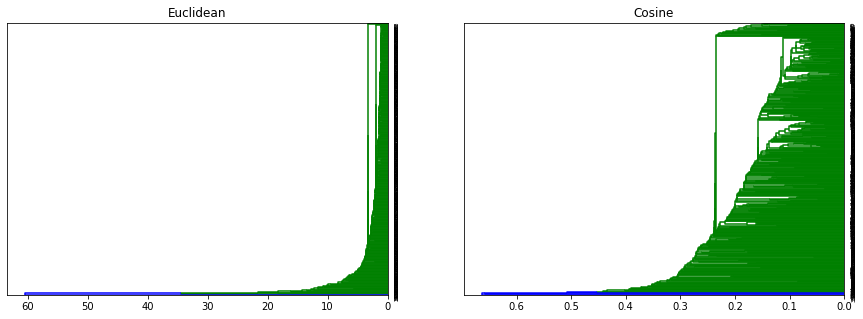

In [ ]:
# both plots
LINKS = [hclust_e, hclust_c]
TITLE = ['Euclidean', 'Cosine']

plt.figure(figsize=(15, 5))

# loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1, 2, i+1)
  plt.title(TITLE[i])
  dendrogram(m,
            #  labels = ps.index,
             leaf_rotation=90,
            #  leaf_font_size=10,
             orientation="left")
  
plt.show()

The plots are hard to read, but we can get a sense of the shape of how the clustering is taking place. Euclidean is incremental, with larger groups joining late. Both identified outliers, though cosine appears to suggest more with smaller groups uniting earlier in the algorithm. I will go with cosine.

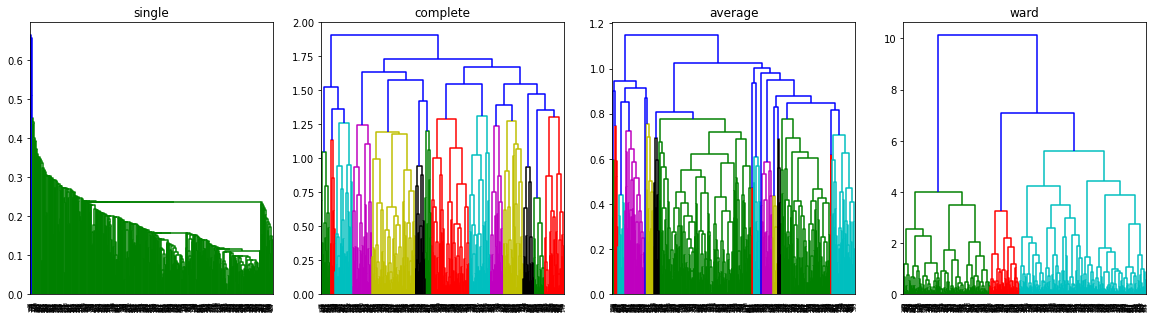

In [ ]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m), 
             leaf_rotation=90)
  
plt.show()


> For this business problem, I actually like the segmentation and the "lanes" that are created as part of the complete linkage. So, I will use cosine + complete linkage to form the clusters.  Because there are a number of clusters, I am going to stay with 7, as not not overly condense the segmentation lanes that we see in the plot.

In [ ]:
# the labels 
labs = fcluster(linkage(distc, method="complete"), 7, criterion="maxclust")

# confirm
np.unique(labs)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# lets put this back onto the players dataset
stock['cluster'] = labs

In [ ]:
# quick review
stock.head(3)

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth,calculated_book_val_per_share,Dividend Yield,Current-Highest Price Ratio,cluster
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
URI,81102622,81102622,1,16354000000,1.692000e+09,13020000000,2.087000e+09,3334000000,0,0,5208000000,9182000000,2.116000e+09,333000000,333000000,4.05,4.01,0.00,4.740000e+08,-1.388000e+09,8.630000e+08,-52000000,65000000,839000000,157.81,173.00,142.61,0.5317,0.1100,41.11,4.13,8.70,0.00,0.0000,2.7540,0.2039,0.2196,0.50,-4.50,0.8107,URI,2018-09-30,2018,2018Q3,2018M9,6.210484,0.000000,0.912197,2
AJG,183652000,183652000,1,16114700000,8.084000e+09,11502000000,7.422600e+09,4544500000,68200000,0,6273400000,3141200000,1.778500e+09,127600000,127600000,0.70,0.68,0.41,1.913000e+08,-2.081000e+08,-4.480000e+07,-84200000,2260500000,28100000,70.75,76.49,65.00,0.1411,0.0405,24.75,2.91,20.93,23.61,0.4759,0.6912,0.2820,0.0904,0.45,0.89,1.0891,AJG,2018-09-30,2018,2018Q3,2018M9,8.465370,0.005795,0.924958,6
JPM,3325410725,3325410725,1,2615183000000,0.000000e+00,2356227000000,0.000000e+00,258956000000,0,27764000000,0,0,2.726000e+10,8380000000,8380000000,2.35,2.34,0.80,1.318900e+10,-8.080000e+08,2.553000e+09,13917000000,419097000000,0,110.72,119.24,102.20,0.1226,0.0115,69.52,1.61,14.78,30.52,0.2961,0.0000,0.0884,0.2641,0.04,3.97,0.0000,JPM,2018-09-30,2018,2018Q3,2018M9,430.658142,0.007225,0.928547,1


In [ ]:
# lets profile the cluster solutions
clus_profile = stock.groupby("cluster").mean()

clus_profile.T

cluster,1,2,3,4,5,6,7
Shares,2.053966e+09,3.944113e+08,3.354917e+08,6.889536e+08,2.703335e+08,2.414661e+08,2.018601e+08
Shares split adjusted,2.053966e+09,3.944113e+08,3.354917e+08,6.889536e+08,2.703335e+08,2.414661e+08,2.018601e+08
Split factor,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Assets,3.132163e+11,2.034082e+10,5.751549e+10,1.427984e+11,1.389855e+10,1.780760e+10,1.210141e+10
Current Assets,2.950503e+10,2.623070e+09,8.584260e+08,1.360415e+10,3.420921e+09,5.308573e+09,5.248469e+09
Liabilities,2.522418e+11,1.247185e+10,4.717559e+10,1.185041e+11,9.644343e+09,1.273463e+10,7.183299e+09
Current Liabilities,2.096521e+10,2.317236e+09,1.215234e+09,1.261303e+10,2.463215e+09,4.237460e+09,3.566418e+09
Shareholders equity,6.035286e+10,7.781804e+09,1.013585e+10,2.268948e+10,4.088655e+09,4.985906e+09,4.827817e+09
Non-controlling interest,6.216712e+08,8.717281e+07,2.040467e+08,1.604842e+09,1.655535e+08,8.705752e+07,9.029608e+07
Preferred equity,1.239119e+09,1.858306e+08,2.907110e+08,5.192336e+08,2.207182e+07,2.527869e+07,1.184211e+02


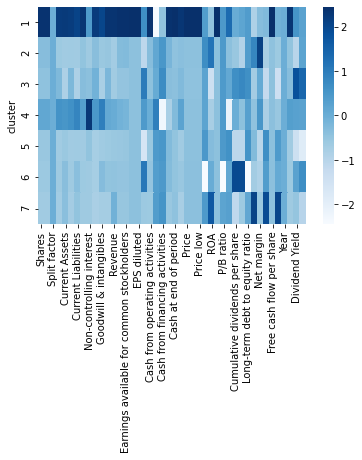

In [ ]:
# we can also plot this as a heatmap, but we should normalize the data
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=clus_profile.index, 
                              columns=clus_profile.columns)

sns.heatmap(cluster_scaled, cmap="Blues", center=0)

Some example findings from the profiling.  Recall that we only used select variables and that they were scaled!

- It's easy to see that some clusters have higher averages in various metrics than others
- Sometimes a cluster is average, while others tend to overperform/underpeform overall
- I won't go into specifics relative to the game of hockey, but it's not surprising that "leadership" type skills (e.g. faceoff information) stands out.
- Not all of the states were game adjusted (rate stats).  That could be an area of improvement for this exercise.
- If this were a truly robust deliverable, we would want to think about giving each cluster a persona, or one that describes the "typical" player in the assignment.  

> This is a common task for marketing segmentation where we want to characterize each segment via a story that can be used for positioning, etc.



In [ ]:
# group by team and pivot on cluster, count
stock_cluster = pd.crosstab(stock.index, stock.cluster, normalize = 0)
stock_cluster

cluster,1,2,3,4,5,6,7
row_0,,,,,,,
AAN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAPL,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ABBV,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ABC,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ABK,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
XYL,0.0,0.0,0.0,0.0,1.0,0.0,0.0
YUM,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZION,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
stock_cluster.head(3)

cluster,1,2,3,4,5,6,7
row_0,,,,,,,
AAN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAPL,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ABBV,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

stock1 = df_2018.copy()
stock1 = stock1.reset_index(drop=True)
stock1.head(3)

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth,calculated_book_val_per_share,Dividend Yield,Current-Highest Price Ratio
0,81102622,81102622,1,16354000000,1.692000e+09,13020000000,2.087000e+09,3334000000,0,0,5208000000,9182000000,2.116000e+09,333000000,333000000,4.05,4.01,0.00,4.740000e+08,-1.388000e+09,8.630000e+08,-52000000,65000000,839000000,157.81,173.00,142.61,0.5317,0.1100,41.11,4.13,8.70,0.00,0.0000,2.7540,0.2039,0.2196,0.50,-4.50,0.8107,URI,2018-09-30,2018,2018Q3,2018M9,6.210484,0.000000,0.912197
1,183652000,183652000,1,16114700000,8.084000e+09,11502000000,7.422600e+09,4544500000,68200000,0,6273400000,3141200000,1.778500e+09,127600000,127600000,0.70,0.68,0.41,1.913000e+08,-2.081000e+08,-4.480000e+07,-84200000,2260500000,28100000,70.75,76.49,65.00,0.1411,0.0405,24.75,2.91,20.93,23.61,0.4759,0.6912,0.2820,0.0904,0.45,0.89,1.0891,AJG,2018-09-30,2018,2018Q3,2018M9,8.465370,0.005795,0.924958
2,3325410725,3325410725,1,2615183000000,0.000000e+00,2356227000000,0.000000e+00,258956000000,0,27764000000,0,0,2.726000e+10,8380000000,8380000000,2.35,2.34,0.80,1.318900e+10,-8.080000e+08,2.553000e+09,13917000000,419097000000,0,110.72,119.24,102.20,0.1226,0.0115,69.52,1.61,14.78,30.52,0.2961,0.0000,0.0884,0.2641,0.04,3.97,0.0000,JPM,2018-09-30,2018,2018Q3,2018M9,430.658142,0.007225,0.928547


In [ ]:
stock_group = stock1.loc[:, ["ticker", "Dividend Yield"]]
stock_group

,ticker,Dividend Yield
0,URI,0.000000
1,AJG,0.005795
2,JPM,0.007225
3,ESRX,0.000000
4,RTN,0.004371
...,...,...
449,SWKS,0.004064
450,LRCX,0.006364
451,PEP,0.008309
452,BBBY,0.008201


In [ ]:
# now lets get the cluster profile aligned
stock_cluster2 = team_cluster.reset_index(drop=False, inplace=False)
stock_cluster2.rename(columns={'row_0':'ticker'}, inplace=True)
stock_cluster2.head(3)

cluster,ticker,1,2,3,4,5,6,7
0,AAN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,AAPL,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ABBV,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# finally append the data
stock_profile = pd.merge(stock_group, stock_cluster2, how="inner")
stock_profile.head(3)

,ticker,Dividend Yield,1,2,3,4,5,6,7
0,URI,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,AJG,0.005795,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,JPM,0.007225,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# lets create a compounded key
stock_profile['stock_dividend_yield'] = stock_profile.ticker + "-" + stock_profile['Dividend Yield'].astype('str')

stock_profile.head(3)

,ticker,Dividend Yield,1,2,3,4,5,6,7,stock_dividend_yield
0,URI,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,URI-0.0
1,AJG,0.005795,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AJG-0.005795053003533569
2,JPM,0.007225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,JPM-0.007225433526011561


In [ ]:
# heatmap the constuction
# hack

plt.figure(figsize=(20, 10))

tmp = stock_profile.drop(columns=["ticker", "Dividend Yield"])


sns.heatmap(tmp.groupby("stock_dividend_yield").mean(), cmap="Greens")

NameError: ignored

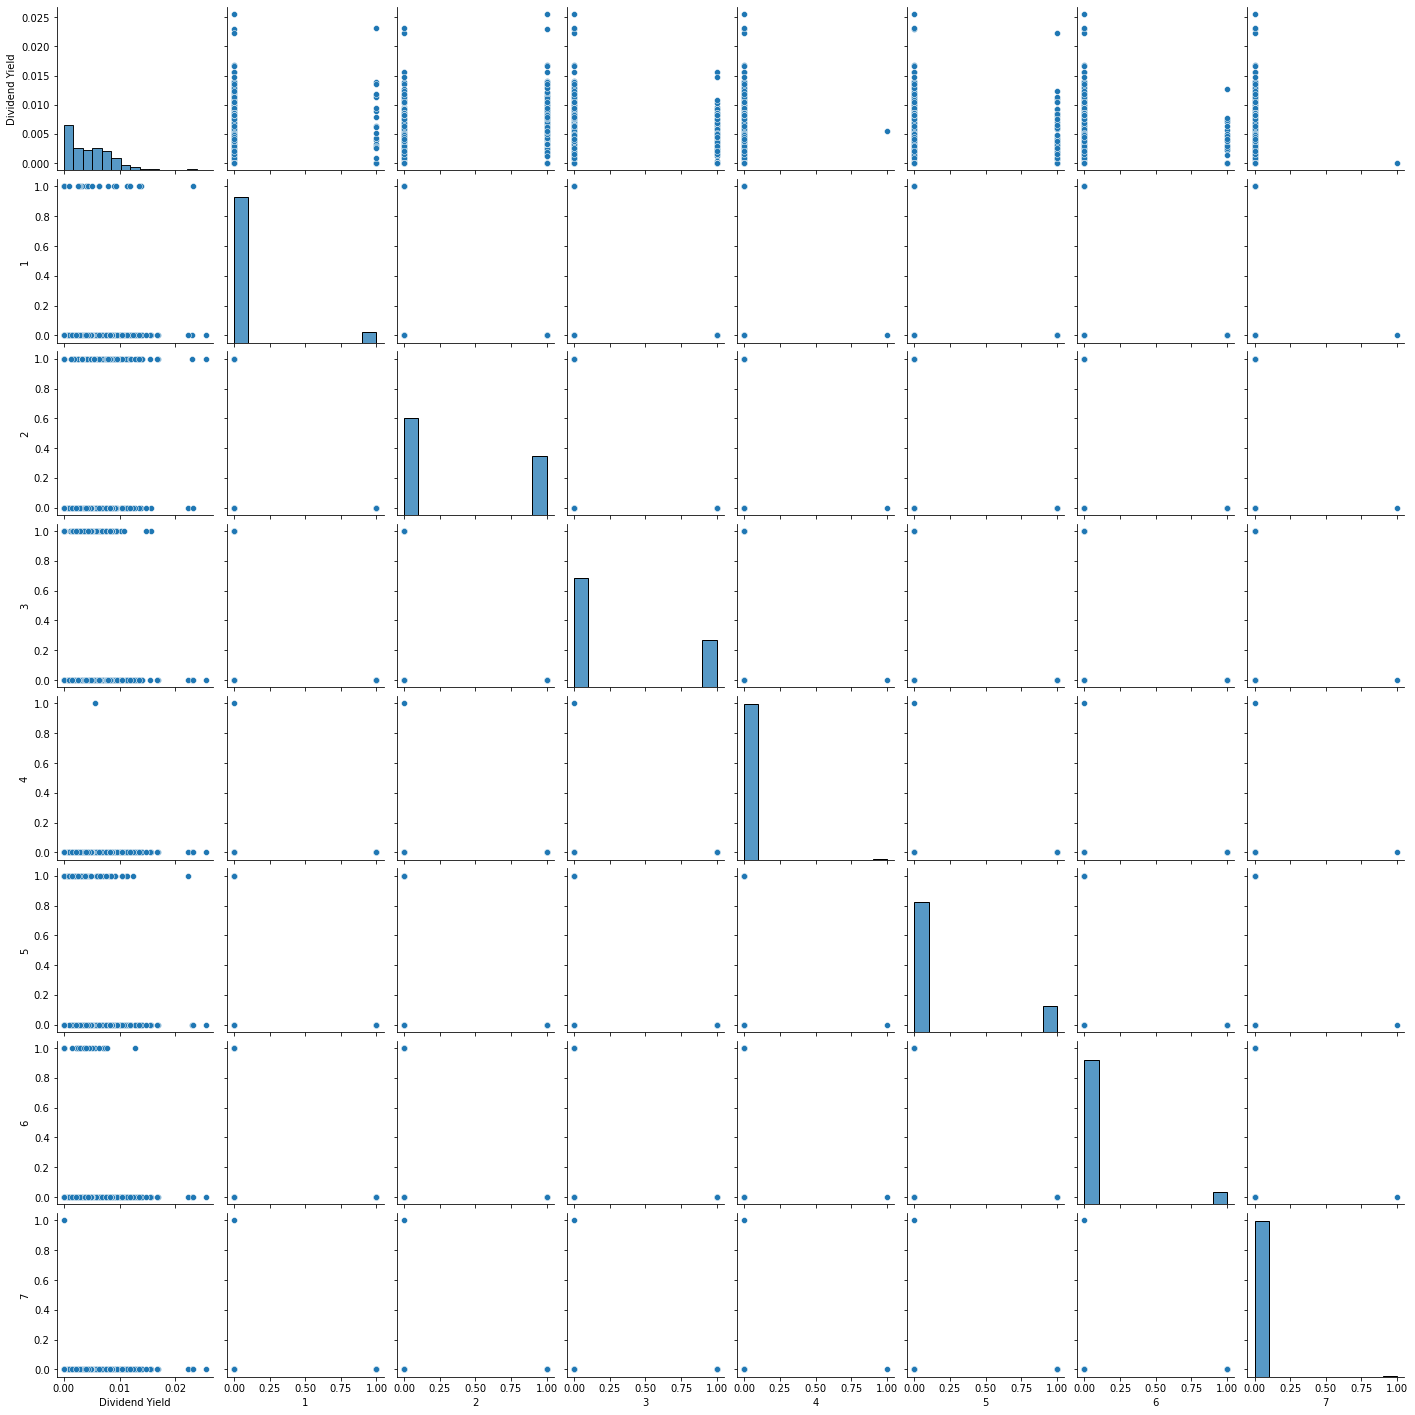

In [ ]:
sns.pairplot(stock_profile)

# K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=4)

In [ ]:
sc = StandardScaler()
st = sc.fit_transform(stock_num)

st = pd.DataFrame(st, columns=stock_num.columns)

In [ ]:
kmeans.fit(st)

stock_k = kmeans.predict(st)
stock['c4'] = stock_k

In [ ]:
stock

,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,Year,Quarter,Yearmonth,calculated_book_val_per_share,Dividend Yield,Current-Highest Price Ratio,cluster,c4
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
URI,81102622,81102622,1,16354000000,1.692000e+09,13020000000,2.087000e+09,3334000000,0,0,5208000000,9182000000,2.116000e+09,333000000,333000000,4.05,4.01,0.0000,4.740000e+08,-1.388000e+09,8.630000e+08,-52000000,65000000,839000000,157.81,173.00,142.61,0.5317,0.1100,41.11,4.13,8.70,0.00,0.0000,2.7540,0.2039,0.2196,0.50,-4.50,0.8107,URI,2018-09-30,2018,2018Q3,2018M9,6.210484,0.000000,0.912197,2,1
AJG,183652000,183652000,1,16114700000,8.084000e+09,11502000000,7.422600e+09,4544500000,68200000,0,6273400000,3141200000,1.778500e+09,127600000,127600000,0.70,0.68,0.4100,1.913000e+08,-2.081000e+08,-4.480000e+07,-84200000,2260500000,28100000,70.75,76.49,65.00,0.1411,0.0405,24.75,2.91,20.93,23.61,0.4759,0.6912,0.2820,0.0904,0.45,0.89,1.0891,AJG,2018-09-30,2018,2018Q3,2018M9,8.465370,0.005795,0.924958,6,1
JPM,3325410725,3325410725,1,2615183000000,0.000000e+00,2356227000000,0.000000e+00,258956000000,0,27764000000,0,0,2.726000e+10,8380000000,8380000000,2.35,2.34,0.8000,1.318900e+10,-8.080000e+08,2.553000e+09,13917000000,419097000000,0,110.72,119.24,102.20,0.1226,0.0115,69.52,1.61,14.78,30.52,0.2961,0.0000,0.0884,0.2641,0.04,3.97,0.0000,JPM,2018-09-30,2018,2018Q3,2018M9,430.658142,0.007225,0.928547,1,3
ESRX,563860000,563860000,1,55441600000,1.435220e+10,34868800000,1.869140e+10,20565900000,6900000,0,39536000000,12974200000,2.556320e+10,1071600000,1071600000,1.90,1.89,0.0000,7.594000e+08,-6.910000e+07,6.910000e+07,763400000,3705700000,65500000,84.22,96.45,72.00,0.2562,0.0900,36.47,2.44,10.26,0.00,0.0000,0.6309,0.3709,0.0483,1.86,1.23,0.7679,ESRX,2018-09-30,2018,2018Q3,2018M9,38.309597,0.000000,0.873199,7,1
RTN,284577000,284577000,1,30134000000,1.063500e+10,18264000000,7.156000e+09,11310000000,560000000,0,14865000000,4753000000,6.806000e+09,644000000,644000000,2.25,2.25,0.8675,-4.440000e+08,-2.000000e+08,-3.730000e+08,-1017000000,2085000000,194000000,198.46,210.89,186.03,0.2346,0.0808,39.74,5.34,23.94,32.00,0.3942,0.4202,0.3753,0.0933,0.87,-2.24,1.4862,RTN,2018-09-30,2018,2018Q3,2018M9,21.067959,0.004371,0.941059,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWKS,177531995,177531995,1,4828900000,2.262200e+09,731900000,3.897000e+08,4097000000,0,0,1333500000,0,1.008400e+09,285500000,285500000,1.60,1.58,0.3800,2.076000e+08,-3.412000e+08,-2.912000e+08,-424800000,733300000,112300000,93.50,103.95,83.05,0.2275,0.1938,23.08,4.10,18.85,4.43,0.2628,0.0000,0.8484,0.2374,0.82,0.54,5.8050,SWKS,2018-09-28,2018,2018Q3,2018M9,7.631780,0.004064,0.899471,7,1
LRCX,155182806,155182806,1,10957577000,7.515873e+09,5575940000,2.824965e+09,5322825000,58812000,0,1767562000,1805091000,2.330691e+09,533360000,533360000,3.43,3.23,1.1000,7.202860e+08,-6.723310e+08,-1.990193e+09,-1944549000,2824009000,56098000,172.86,196.70,149.02,0.3752,0.1858,34.30,4.19,13.69,7.52,0.2185,0.3391,0.4858,0.2126,0.87,4.28,2.6605,LRCX,2018-09-23,2018,2018Q3,2018M9,9.915213,0.006364,0.878800,7,1
PEP,1411568000,1411568000,1,73632000000,2.584200e+10,6324300

In [ ]:
#first is using inertia 
KRANGE = range(2, 30)

# store
ss = []

#loop over and evaluate

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock)
  ss.append(km.inertia_) #inertia for the fit

ValueError: ignored